In [ ]:
'''
UMAP of STATE Embeddings
'''

In [1]:
# Imports
import pandas as pd
import scanpy as sc
import os
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import anndata as ad
import pyarrow.parquet as pq
import rapids_singlecell as rsc

from matplotlib import patheffects
import time

import psutil
import pyarrow as pa
import seaborn as sns

In [2]:
# File Paths
HUMAN_EMBEDS_PQ = '/large_storage/ctc/userspace/rohankshah/homo_sapiens.parquet'
HUMAN_CT_FP = '/large_storage/goodarzilab/arshian/state_ct_obs/Homo_sapiens'
META_FP = '/large_storage/ctc/public/scBasecamp/metadata_tsp_annotated_2.parquet'

In [3]:
# Get the metadata
raw_metadata = pd.read_parquet(META_FP)

# Filter for quality
metadata_filtered = raw_metadata[(raw_metadata['organism'] == 'Homo sapiens') & (raw_metadata['mean_umi_per_cell'] > 100)].copy()
annotated_srxs = [filename.replace('.parquet', '') for filename in os.listdir(HUMAN_CT_FP)]

# Get overlapping_srxs
overlapping_srxs = set(metadata_filtered['srx_accession'].values).intersection(set(annotated_srxs))
metadata = metadata_filtered[metadata_filtered['srx_accession'].isin(overlapping_srxs)].copy()

In [4]:
with open('cell_type_distributions/ct_categorized_ontology_08_16_2025.json', 'r') as file:
    cell_type_mapping = json.load(file)
with open('cell_type_distributions/ct_categorized_ontology_toplevel_08_15_2025.json', 'r') as file:
    cell_type_mapping_top = json.load(file)

In [5]:
cell_type_mapping_top

{'CD4-positive, alpha-beta T cell': 'leukocyte',
 'naive thymus-derived CD4-positive, alpha-beta T cell': 'leukocyte',
 'CD8-positive, alpha-beta T cell': 'leukocyte',
 'natural killer cell': 'leukocyte',
 'hematopoietic precursor cell': 'hematopoietic precursor cell',
 'plasma cell': 'leukocyte',
 'mature NK T cell': 'leukocyte',
 'non-classical monocyte': 'progenitor/stem cell',
 'macrophage': 'leukocyte',
 'classical monocyte': 'progenitor/stem cell',
 'B cell': 'leukocyte',
 'intermediate monocyte': 'progenitor/stem cell',
 'hematopoietic stem cell': 'progenitor/stem cell',
 'platelet': 'myeloid cell',
 'erythrocyte': 'myeloid cell',
 'monocyte': 'progenitor/stem cell',
 'neutrophil': 'leukocyte',
 'plasmacytoid dendritic cell': 'leukocyte',
 'basophil': 'leukocyte',
 'neuron': 'neural cell',
 'oligodendrocyte': 'neural cell',
 'astrocyte': 'neural cell',
 'oligodendrocyte precursor cell': 'progenitor/stem cell',
 'central nervous system macrophage': 'leukocyte',
 'endothelial cell

In [6]:
# Randomly sample ~50K Cells per tissue and put together the SRXs

def sample_srxs(metadata, num_cells, tissue=None):
    if tissue:
        metadata_subset = metadata[metadata['tissue_tsp'] == tissue].copy()
    else:
        total_srxs = []
        for tissue in metadata['tissue_tsp'].unique():
            tissue_srxs = sample_srxs(metadata, num_cells, tissue=tissue)
            total_srxs += tissue_srxs
        return total_srxs
    
    random.seed(42)
    shuffled_srxs = list(metadata_subset['srx_accession'].values)
    random.shuffle(shuffled_srxs)
    
    sampled_srxs = []
    total_cells = 0
    
    for srx in shuffled_srxs:
        if total_cells >= num_cells:
            break
        srx_cells = metadata_subset[metadata_subset['srx_accession'] == srx]['estimated_number_of_cells'].iloc[0]
        sampled_srxs.append(srx)
        total_cells += srx_cells
    
    return sampled_srxs

def extract_rows_by_srx(parquet_path, srx_list):
    """
    Extract all rows from STATE embeddings parquet file whose 'dataset' column matches any SRX in `srx_list`
    """
    srx_set = set(srx_list)
    pf = pq.ParquetFile(parquet_path)
    
    print(f"Scanning {pf.num_row_groups} row groups for {len(srx_set)} SRX accessions...")

    matched_tables = []
    for i in tqdm(range(pf.num_row_groups), desc="Scanning row groups"):
        dataset_column = pf.read_row_group(i, columns=['dataset'])['dataset']
        dataset_list = dataset_column.to_pylist()

        # Find matching row indices in this row group
        matched_indices = [j for j, srx in enumerate(dataset_list) if srx in srx_set]

        if matched_indices:
            full_table = pf.read_row_group(i)
            matched_table = full_table.take(matched_indices)
            matched_tables.append(matched_table)

    if not matched_tables:
        raise ValueError("No matching rows found for given SRXs.")
    
    print(f"Found {sum(t.num_rows for t in matched_tables)} total rows across all SRXs")
    final_table = pa.concat_tables(matched_tables)
    df = final_table.to_pandas()
    return df

def get_state_adatas(srxs, embeds_dir, ct_dir):
    embeds_df = extract_rows_by_srx(embeds_dir, srxs)
    print(f"   Loaded {len(embeds_df)} embedding rows, {len(embeds_df.columns)} columns")

    embeds_df['unique_cell'] = embeds_df['dataset'] + '_' + embeds_df['cell']
    embeds_df = embeds_df.set_index('unique_cell').drop(['cell', 'dataset'], axis=1)
    print(f"   Processed to {embeds_df.shape[0]} cells x {embeds_df.shape[1]} features")
        
    def load_ct(srx):
        ct_df = pd.read_parquet(f"{ct_dir}/{srx}.parquet")
        ct_df.index = srx + '_' + ct_df.index.astype(str)
        return ct_df
    
    cell_types_list = []
    for srx in tqdm(set(srxs), desc="Loading cell types"):
        cell_types_list.append(load_ct(srx))

    all_cell_types = pd.concat(cell_types_list)
    print(f"Total cell types: {len(all_cell_types)}")
    
    common_cells = embeds_df.index.intersection(all_cell_types.index)
    print(f"Found {len(common_cells)} overlapping cells")
    print(f"Coverage: {len(common_cells)/len(embeds_df)*100:.1f}% of embeddings")
    
    embeds_aligned = embeds_df.loc[common_cells]
    cell_types_aligned = all_cell_types.loc[common_cells]
    
    adata = ad.AnnData(obs=cell_types_aligned)
    adata.obsm["X_embed"] = embeds_aligned.values
    print(f"Final AnnData: {adata.n_obs} cells, {adata.n_vars} vars")
    
    return adata

def concatenate_adatas(metadata, num_cells, sampled_srxs=None, tissue=None):
    if sampled_srxs is None:
        sampled_srxs = sample_srxs(metadata, num_cells, tissue=tissue)
    total_cell_count = metadata[metadata['srx_accession'].isin(sampled_srxs)]['estimated_number_of_cells'].sum()
    print(f'Retrieved sample of SRXs, Total Cell Count: {total_cell_count}')
    full_state_adata = get_state_adatas(sampled_srxs, HUMAN_EMBEDS_PQ, HUMAN_CT_FP)
    full_state_adata.obs['cell_type_mapped'] = full_state_adata.obs['cell_type'].map(cell_type_mapping)
    print('Successfully concatenated adatas')
    return full_state_adata

In [16]:
# Compute and plot UMAPs
def compute_umap(adata):
    rsc.pp.neighbors(adata, use_rep="X_embed")
    rsc.tl.umap(adata, random_state=42)

def generate_distinct_colors(n_colors):
    if n_colors <= 10:
        return sns.color_palette("tab10", n_colors)
    elif n_colors <= 20:
        return sns.color_palette("tab20", n_colors)
    else:
        palettes = [
            sns.color_palette("tab20", 20),
            sns.color_palette("Set3", 12),
            sns.color_palette("Pastel1", 9),
            sns.color_palette("Pastel2", 8),
            sns.color_palette("Dark2", 8),
            sns.color_palette("Set1", 9),
            sns.color_palette("Set2", 8)
        ]
        
        all_colors = []
        for palette in palettes:
            all_colors.extend(palette)
            if len(all_colors) >= n_colors:
                break
        
        return all_colors[:n_colors]

# Adapted from scanpy github
def plot_umap(adata, color_col, tissue=None, 
                          legend_loc='right margin', 
                          legend_fontsize=None, 
                          legend_fontweight=None,
                          legend_fontoutline=None,
                          size=None,
                          alpha=None,
                          title=None,
                          percentile_limits=[0, 100],
                          figsize=(10, 8)):
    
    umap_coords = adata.obsm['X_umap']
    x_limits = np.percentile(umap_coords[:, 0], percentile_limits)
    y_limits = np.percentile(umap_coords[:, 1], percentile_limits)
    
    x_mask = (umap_coords[:, 0] >= x_limits[0]) & (umap_coords[:, 0] <= x_limits[1])
    y_mask = (umap_coords[:, 1] >= y_limits[0]) & (umap_coords[:, 1] <= y_limits[1])
    main_cells_mask = x_mask & y_mask
    
    coords = umap_coords[main_cells_mask]
    cell_types = adata.obs[color_col].astype('category')[main_cells_mask]
    
    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    
    if size is None:
        size = 120000 / len(coords)
        size = max(0.1, min(size, 20))
    
    if alpha is None:
        alpha = 0.8 if len(coords) > 10000 else 1.0
    
    n_cats = len(cell_types.cat.categories)
    palette = generate_distinct_colors(n_cats)
    
    color_map = dict(zip(cell_types.cat.categories, palette))
    
    for i, cat in enumerate(cell_types.cat.categories):
        mask = cell_types == cat
        if mask.sum() == 0:
            continue
            
        ax.scatter(
            coords[mask, 0], 
            coords[mask, 1],
            c=[color_map[cat]], 
            s=size,
            alpha=alpha,
            edgecolor='none',
            rasterized=True,
            label=cat
        )
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP1', fontsize=12)
    ax.set_ylabel('UMAP2', fontsize=12)
    
    if title is None:
        title = f"Cross-Tissue UMAP, Cell Count: {len(coords):,}"
    ax.set_title(title, fontsize=14, pad=20)
    
    if legend_loc == 'right margin':
        legend = ax.legend(
            bbox_to_anchor=(1.05, 0.5), 
            loc='center left',
            frameon=False,
            fontsize=legend_fontsize or 10,
            markerscale=22,
            markerfirst=True
        )
        
        for text in legend.get_texts():
            text.set_fontweight(legend_fontweight)
            
        if legend_fontoutline is not None:
            for text in legend.get_texts():
                text.set_path_effects([
                    patheffects.withStroke(linewidth=legend_fontoutline, foreground='w')
                ])
                
    elif legend_loc == 'on data':
        for cat in cell_types.cat.categories:
            mask = cell_types == cat
            if mask.sum() == 0:
                continue
                
            center_x = np.median(coords[mask, 0])
            center_y = np.median(coords[mask, 1])
            
            text_effects = []
            if legend_fontoutline is not None:
                text_effects.append(
                    patheffects.withStroke(linewidth=legend_fontoutline, foreground='w')
                )
            
            ax.text(
                center_x, center_y, cat,
                fontsize=legend_fontsize or 8,
                ha='center', va='center',
                fontweight=legend_fontweight,
                path_effects=text_effects,
                bbox=dict(boxstyle='round,pad=0.2', 
                         facecolor='white', 
                         alpha=0.8,
                         edgecolor='none')
            )
    
    plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.1)
    
    return fig, ax


In [8]:
total_adata = concatenate_adatas(metadata, 50000)

Retrieved sample of SRXs, Total Cell Count: 1395397
Scanning 3536 row groups for 201 SRX accessions...


Scanning row groups: 100%|██████████████████| 3536/3536 [05:13<00:00, 11.27it/s]


Found 1309656 total rows across all SRXs
   Loaded 1309656 embedding rows, 2060 columns
   Processed to 1309656 cells x 2058 features


Loading cell types: 100%|████████████████████| 201/201 [00:01<00:00, 161.33it/s]


Total cell types: 1309656
Found 1309656 overlapping cells
Coverage: 100.0% of embeddings
Final AnnData: 1309656 cells, 0 vars
Successfully concatenated adatas


In [9]:
# Add tissue labels and fix mapping
srx_to_tissue = dict(zip(metadata['srx_accession'].values, metadata['tissue_tsp'].values))
total_adata.obs['tissue'] = total_adata.obs['SRX_accession'].map(srx_to_tissue)
tissue_mapping = {
    'blood': 'blood',
    'brain': 'brain',
    'bonemarrow': 'bone marrow',
    'lung': 'lung',
    'spleen': 'spleen',
    'eye': 'eye',
    'liver': 'liver',
    'skin': 'skin',
    'muscle': 'muscle',
    'si': 'small intestine',
    'mammary': 'mammary',
    'pancreas': 'pancreas',
    'lymphnode': 'lymph node',
    'heart': 'heart',
    'li': 'large intestine',
    'vasculature': 'vasculature',
    'fat': 'fat',
    'endometrium': 'endometrium',
    'prostate': 'prostate',
    'bladder': 'bladder',
    'trachea': 'trachea',
    'salivarygland': 'salivary gland',
    'tongue': 'tongue',
    'thymus': 'thymus'
}
total_adata.obs['tissue'] = total_adata.obs['tissue'].map(tissue_mapping)

In [10]:
total_adata.obs['cell_type_mapped_top'] = total_adata.obs['cell_type'].map(cell_type_mapping_top)

In [11]:
# Compute the umap
compute_umap(total_adata)

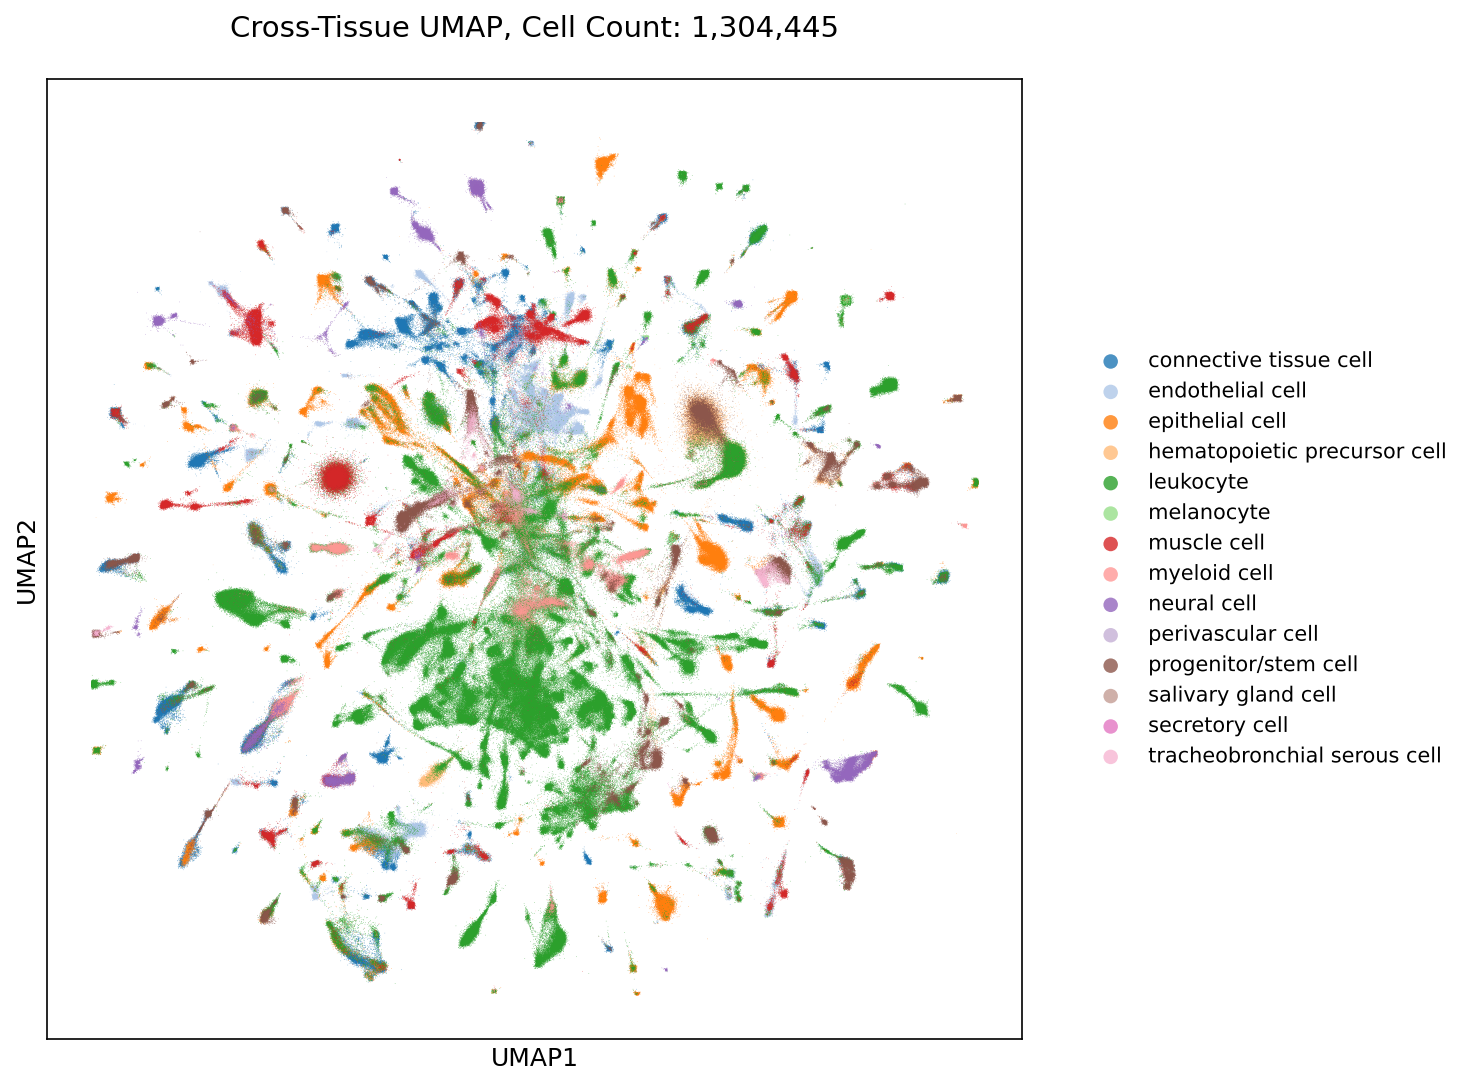

In [18]:
# Cell Type UMAP
fig, ax = plot_umap(
    total_adata,
    'cell_type_mapped_top',
    legend_loc='right margin',
    legend_fontsize=10,
    legend_fontoutline=2,
    size=None,
    percentile_limits=[0.1, 99.9]
)

plt.savefig(f"images/umap_broad.svg", 
                   format='svg',
                   dpi=dpi if format == 'png' else None,
                   bbox_inches='tight',
                   facecolor='white',
                   edgecolor='none')

plt.show()

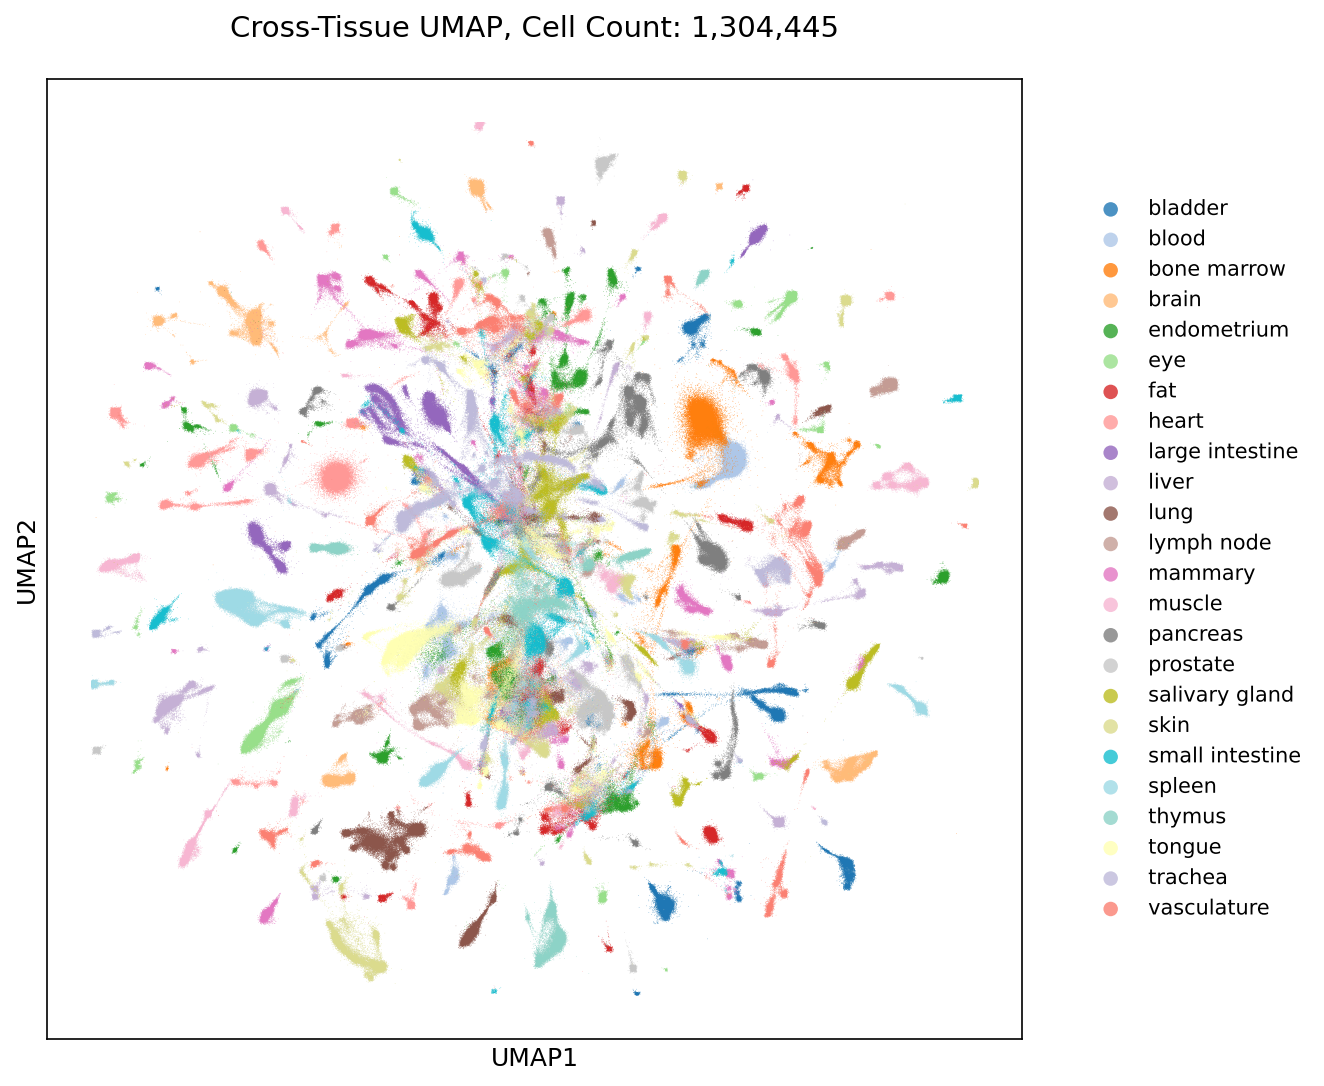

In [17]:
# Tissue UMAP
fig, ax = plot_umap(
    total_adata, 
    'tissue',
    legend_loc='right margin',
    legend_fontsize=10,
    legend_fontoutline=2,
    size=None,
    percentile_limits=[0.1, 99.9]
)

plt.savefig(f"images/umap_tissue.svg", 
                   format='svg',
                   dpi=dpi if format == 'png' else None,
                   bbox_inches='tight',
                   facecolor='white',
                   edgecolor='none')

plt.show()